<div style="margin: 0 auto 10px; height: 70px; border: 2px solid gray; border-radius: 6px;">
  <div style="float: left; margin: 5px 10px 5px 10px; "><img src="img/bfh.jpg" /></div>
  <div style="float: right; margin: 20px 30px 0; font-size: 15pt; font-weight: bold; color: #98b7d2;"><a href="https://moodle.bfh.ch/course/view.php?id=39255" style="color: #98b7d2;">BTE5476 - Project-Oriented Digital Signal Processing </a></div>
</div>
<div style="clear: both; font-size: 30pt; font-weight: bold; color: #64788b; margin-left: 30px;">
    Phase-Locked Loops and More
</div>

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sp
import IPython
from scipy.io import wavfile
import random
import string

In [3]:
plt.rcParams["figure.figsize"] = (9,2.5)

The following functions were originally defined in the notebooks on biquad filters.

In [5]:
def LPF(fc, sf, Q=(1/np.sqrt(2))):
    """Biquad lowpass filter"""
    w = 2 * np.pi * fc / sf
    alpha = np.sin(w) / (2 * Q)
    c = np.cos(w)
    a = np.array([1 + alpha, -2 * c, 1 - alpha])
    b = np.array([(1 - c) / 2, 1 - c, (1 - c) / 2])
    return b / a[0], a / a[0]
    
def BPF(fc, bw, sf):
    """Biquad bandpass filter"""
    w = 2 * np.pi * fc / sf
    alpha = np.tan(np. pi * bw / sf)
    c = np.cos(w)
    b = np.array([alpha, 0, -alpha])
    a = np.array([1 + alpha, -2 * c, 1 - alpha])
    return b / a[0], a / a[0]

def NTCF(fc, bw, sf):
    """Biquad notch filter"""
    w = 2 * np.pi * fc / sf
    alpha = np.tan(np. pi * bw / sf)
    c = np.cos(w)
    b = np.array([1, -2 * c, 1])
    a = np.array([1 + alpha, -2 * c, 1 - alpha])
    return b / a[0], a / a[0]

In [6]:
def analog_response(b, a, sf, dB=-100, half=True, points=2001, axis=None, color='C0', label=None):
    """plot the magnitude response of a digital filter on a log-log scale"""
    EPS = 1e-20
    w = np.linspace(0, np.pi, points)
    A, B = np.zeros(points, dtype='complex'), np.zeros(points, dtype='complex')
    for n, bn in enumerate(b):
        B += bn * np.exp(-1j * n * w)
    for n, an in enumerate(a):
        A += an * np.exp(-1j * n * w)
    M = 20 * np.log10(np.abs(np.where(B == 0, EPS, B) / (np.where(A == 0, EPS, A))))
    
    if axis is None:
        _, axis = plt.subplots()
    axis.plot(np.linspace(0, sf / 2, points), M, color, lw=2, label=label)
    axis.set_xscale('log')
    axis.set_ylabel('dB', color='C0')
    axis.grid(visible=True, which='both')    
    axis.axis('tight')
    axis.set_ylim([max(dB, min(M)), None])  

In [7]:
def plot_mag_spec(data, Fs=2*np.pi, pts=None, maxf=None, minf=None, one_sided=True):
    pts = len(data) if pts is None else pts
    w = Fs * (np.arange(0, pts) / pts - 0.5)
    X = np.abs(np.fft.fftshift(np.fft.fft(data, pts)))
    maxf = Fs / 2 if maxf is None else maxf
    minf = -Fs / 2 if minf is None else minf
    if one_sided and minf < 0:
        minf = 0
    start = max(0, int(pts * (Fs / 2 + minf) / Fs))
    stop = min(pts, int(pts * (Fs / 2 + maxf) / Fs))
    plt.plot(w[start:stop], X[start:stop]);

In [8]:
Fs = 32000  # default sampling rate for the examples in the notebook

# Remote Synchronization

Consider the problem of sending a synchronization event to a remote device; for example, imagine we need to "wake up" a data receiver to signal that a data payload is incoming, or that we need to synchronize the internal clock of the remote device to a specific time reference.

To do this, we need to design a signal with an identifiable feature that is well localized in time, and we need to make sure that this feature remains clearly identifiable after the signal is transmitted over the communication channel to the remote device.

## Simple synchronization pulses

The most elementary type of time-localized feature is a sharp amplitude transition: imagine flipping a switch on or off.

Since every communication channel will at the very least introduce some additive noise, in the absence of other impairments we just need to make sure that the amplitude rises clearly above the noise floor; at the receiving end, the transition instant can be recovered by thresholding. For example we can use a simple pulse:

In [11]:
N = 8000  # length of signal
T = 4100  # time of pulse

noise_floor = np.random.rand(N) - 0.5

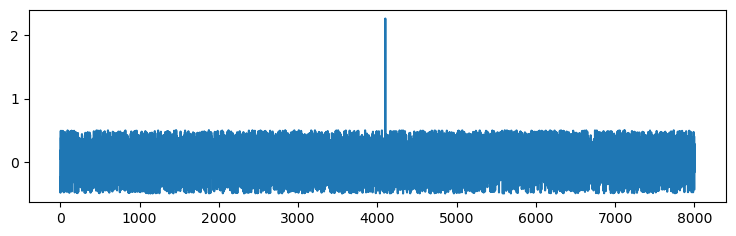

In [12]:
x = noise_floor.copy()
x[T] += 2.5
plt.plot(x);

Unfortunately this is not going to work the moment we need to send the synchronization signal over a bandlimited channel; for example:

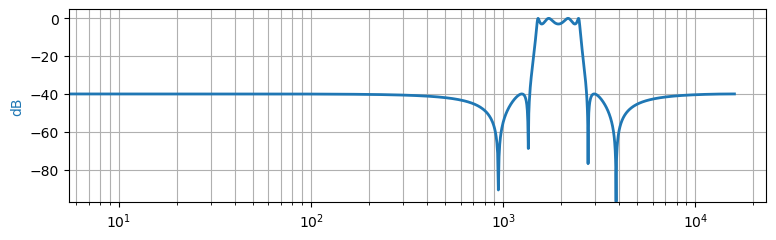

In [14]:
channel_bw = [1500, 2500]
channel_mid = np.mean(channel_bw)
channel = sp.ellip(4, 3, 40, channel_bw, 'bandpass', fs=Fs)
analog_response(*channel, Fs, half=True)

In [15]:
def pre_post(x, channel):
    plt.figure(figsize=(9, 4))
    plt.subplot(2,1,1)
    plt.plot(x);
    plt.subplot(2,1,2)
    plt.plot(sp.lfilter(*channel, x), 'C1');

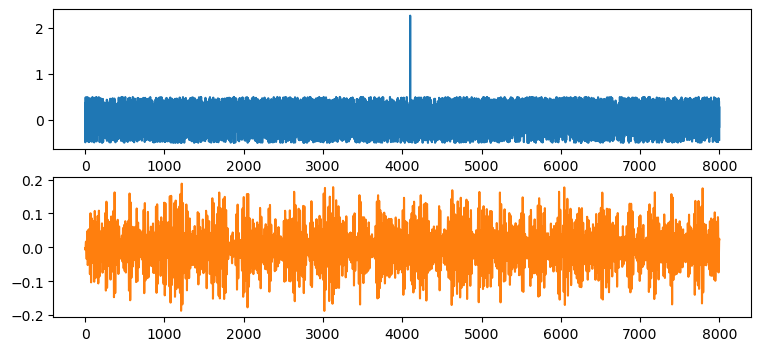

In [16]:
pre_post(x, channel)

We could try to make the pulse wider, or ever use a step signal, but things are not going to improve much: 

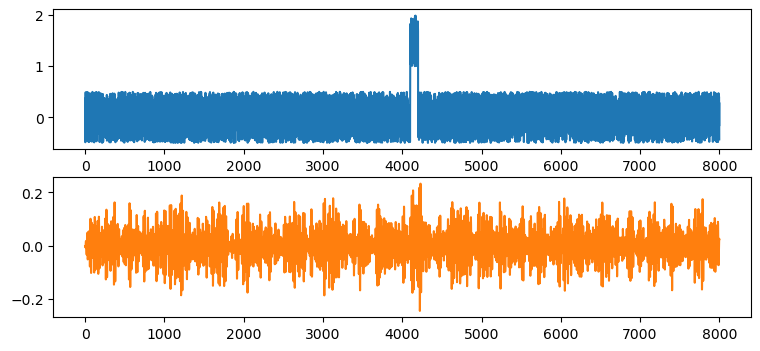

In [18]:
x = noise_floor.copy()
x[T:T+100] += 1.5
pre_post(x, channel)

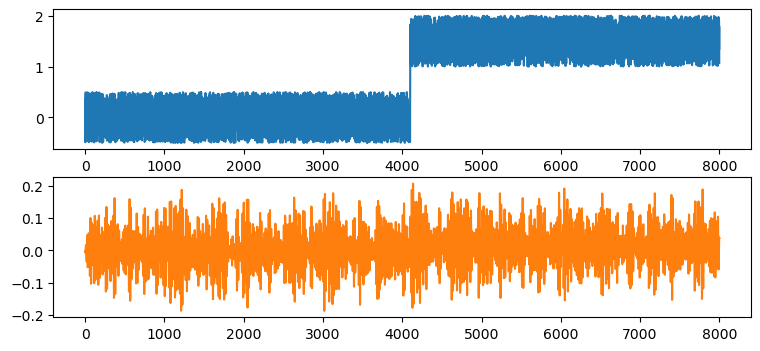

In [19]:
x = noise_floor.copy()
x[T:] += 1.5
pre_post(x, channel)

The problem, of course, is that the spectral energy associated to a sharp amplitude change is spread out over all frequencies; since only a small portion of that energy "survives" the channel, at the receiving end the amplitude of the transition will be much smaller and will fall under the noise floor. We can see this clearly if we remove the noise:

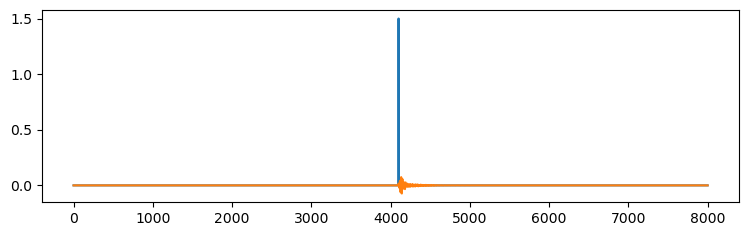

In [21]:
x = np.zeros_like(noise_floor)
x[T] = 1.5
plt.plot(x)
plt.plot(sp.lfilter(*channel, x));

## Modulated pulses

A better approach is to match the synchronization signal to the channel and use modulated pulses instead; this way, most of the energy associated to the transition will not be attenuated during transmission:

In [23]:
# center frequency for our channel
pilot_freq = channel_mid

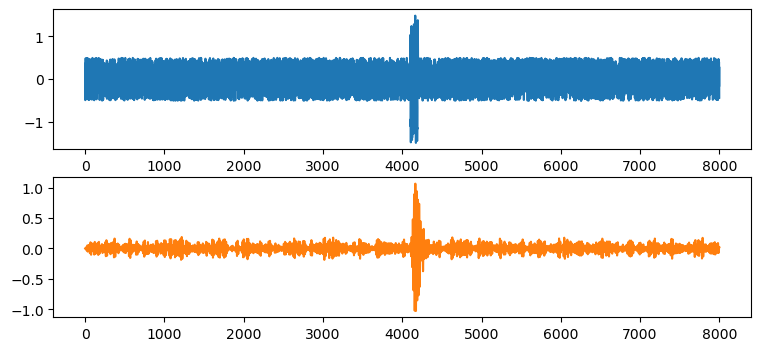

In [24]:
x = noise_floor.copy()
x[T:T+100] += np.cos(2 * np.pi * pilot_freq / Fs * np.arange(0, 100))
pre_post(x, channel)

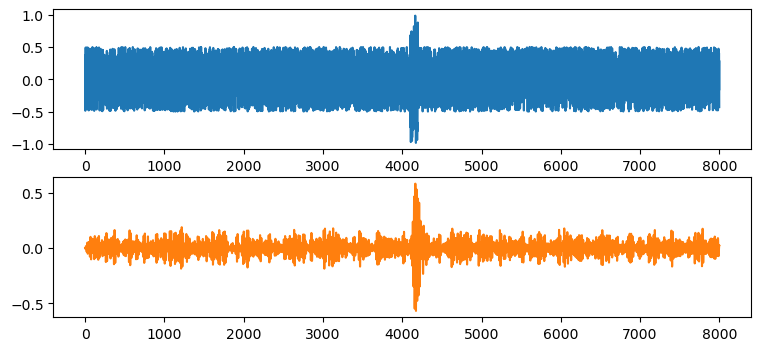

In [25]:
x = noise_floor.copy()
x[T:T+100] += np.cos(2 * np.pi * pilot_freq / Fs * np.arange(0, 100)) / 2
pre_post(x, channel)

## Phase reversal  

When sending a timing reference over a bandlimited channel, it's generally not advisable to use on/off keying (i.e. to send a time-limited pulse); this is because the receiver usually needs to "warm up" to the incoming signal and amplify it so that it reaches the expected power level. 

An more robust solution is to encode the timing reference as a _phase reversal_ in a relatively long _pilot tone_ at a specific frequency: the receiver detects the incoming tone, adjusts the amplification gain, and then waits to detect the phase reversal.

In [27]:
def sync_signal(len_sec, SNR=None, freq_err_perc=0, rev_point=0.5, freq_Hz=2000, sf=32000):
    rev_point = 1 if rev_point <=0 else min(rev_point, 1)
    wp = 2 * np.pi * (1 + freq_err_perc / 100) * freq_Hz / sf 
    N, M = int(len_sec * sf * rev_point), int(len_sec * sf * (1 - rev_point))
    tail = np.cos(wp * np.arange(0, max(N, M)))
    s = np.r_[np.flipud(tail)[-N:], -tail[1:M]]
    if SNR is not None:
        # power of sync sinusoid is 1/2; power of uniform noise is a^2 / 12
        a = np.sqrt(6 * np.power(10, -SNR / 10))
        s += a * (np.random.rand(len(s)) - 0.5)
        # scale signal so that power is 1/2
        s *= np.sqrt(6 / (6 + a * a))
    return s

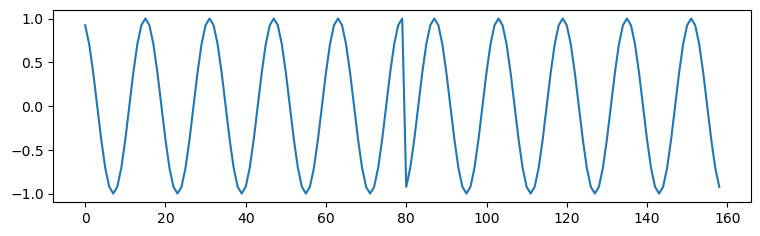

In [28]:
plt.plot(sync_signal(0.005));

A simple method to detect a phase reversal in a pilot uses a bandpass filter to isolate the tone and a notch filter centered on the tone frequency. After a brief lead time, all the energy of the incoming signal is "killed" by the notch but, when the phase reversal occurs, the energy of the signal "spreads out" around the tone frequency and can be easily detected even in the presence of noise:


In [30]:
def show_pr(x, channel=None, pilot_freq_Hz=2000, sf=32000):
    if channel is not None:
        y = sp.lfilter(*channel, x)
    else:
        y = x.copy()
    # using a simple biquad notch centered on the pilot frequency
    y, _ = sp.lfilter(*NTCF(pilot_freq_Hz, 200, sf), y, zi=[-.5, .5])
    plt.plot(x);
    plt.plot(y, 'C3');

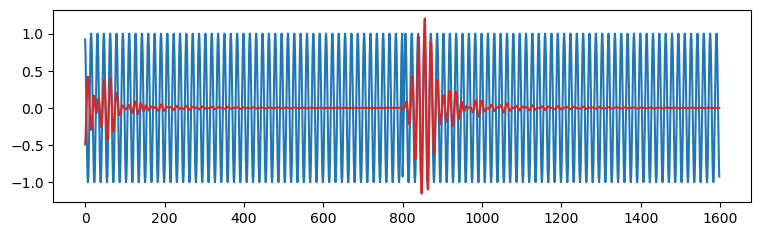

In [31]:
show_pr(sync_signal(0.05), channel=channel)

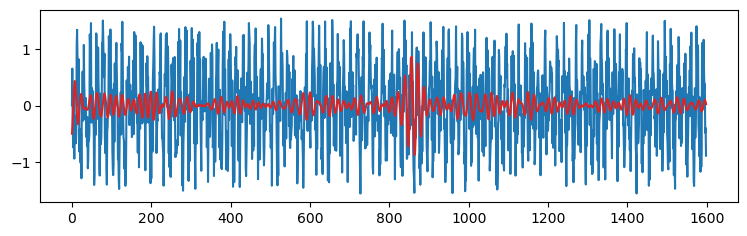

In [161]:
show_pr(sync_signal(0.05, SNR=0), channel=channel)

The problem with this approach is that it's relatively sensitive to the location of the notch; if there is a mismatch with the frequency of the pilot tone, it will be hard or impossible to detect the change in energy associated to the phase reversal:

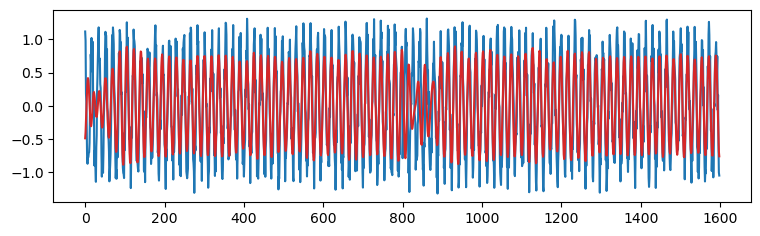

In [34]:
show_pr(sync_signal(0.05, SNR=10, freq_err_perc=-10), channel=channel)

# Phase-Locked Loops

A phase-locked-loop (PLL) is an adaptive signal processing device designed to "lock" on to a periodic input signal and track possible changes in the input's phase and frequency. The generic structure of a PLL is shown in the following diagram:

<div style="margin: 0 auto;"><img src="img/PLL.png" width="600"></div>


At every "time" instant $n$, the PLL estimates the phase offset between the input signal and the signal $y[n]$ generated by its internal oscillator; this offset, after processing by a so-called _loop filter_, is then fed back to the internal oscillator as a control signal to try and keep its output in lock with the input. 

## The NCO

<div style="float:right; margin: 0 10px;"><img src="img/nco.png" width="400"></div>

A Numerically Controlled Oscillator (NCO) is a stateful (i.e. _with memory_) discrete-time device with a user-definable default frequency value $\omega_c$. 


As per the block diagram, at every step $n$:

 * the NCO's internal state variable $\varphi[n]$ (that is, the NCO's internal _phase_) is updated as $$\varphi[n] = \varphi[n-1] + \omega_c + c[n];$$ note that this is equivalent to applying a discrete time integrator (not a leaky one!) on the sequence $\omega_c + c[n]$
 * the NCO's output is computed as $y[n] = p(\varphi[n])$, where $p(\cdot)$ is a $2\pi$-periodic function of its argument

At any point in time:

 * $\varphi[n]$ is the NCO's instantaneous _phase_
 * $\varphi[n] - \varphi[n-1] = \omega_c + c[n]$ is the NCO's instantaneous _frequency_

### A sinusoidal NCO

If we choose $p(\cdot) = \sin(\cdot)$, and assuming zero initial conditions, the NCO's output at time $n$ is 

$$
    y[n] = \sin\varphi[n] = \sin\left(\sum_{k=0}^{n} (\omega_c + c[k])\right) = \sin\left(\omega_c\, n + \sum_{k=0}^{n}c[k]\right)
$$

Some typical cases:

 * if $c[n] = 0$, the NCO will produce a sinusoid at the nominal frequency $\omega_c$
 * if $c[n] = \theta_0 \delta[n-n_0]$, the NCO's output will be shifted in phase by $\theta_0$ radians for $n \ge n_0$
 * if $c[n] = \omega_0 u[n]$, the NCO will produce a sinusoid at frequency $\omega_c + \omega_0$

### Aside: FM radio

In wireless communications the goal is to encode the information of a baseband signal (such as music or voice) onto a high-frequency sinusoidal carrier; the result is a passband signal that matches the physical properties of the frequency band used for radio transmission. This spectral shift of the original baseband signal is called _modulation_.


The simplest type of radio transmission is Amplitude Modulation (AM), where the baseband signal is encoded in the carrier's amplitude:

$$
    s[n] = x[n] \, \cos(\omega_c \, n);
$$

while simple to implement, AM is however very sensitive to additive noise. 

<div style="float:right; margin: 10px;"><img src="img/amfm.png" width="400"></div>


Frequency Modulation (FM) was developed in the 1930s as a noise-resilient alternative (_"FM, no static at all"_); in FM the baseband information is encoded via small variations in the carrier's frequency:

$$
    s[n] = \cos\left(\sum_{k=0}^{n} (\omega_c + \gamma\, x[k])\right)
$$

where $\gamma$ is called the _modulation index_. FM is a nonlinear operation and therefore its theoretical analysis is difficult; it's easy to see, however, that an FM signal has a _constant envelope_ (that is, the amplitude is independent of $x[n]$) which makes it easier to reject additive noise. From the above expression, it's apparent that an FM modulator can be easily implemented digitally using an NCO; originally, in analog radio devices, a Voltage Controlled Oscillator (VCO) was used instead, to produce the analog FM signal 

$$
    s(t) = \cos\left(\int_{\tau=0}^{t} 2\pi f_c + \gamma\, x(\tau)\,\, d\tau\right).
$$

## Phase offset detector

The method to compute the phase offset between the NCO's output and the input depends on the type of waveform that the PLL is designed to track. In a digital PLL we could in principle implement a very sophisticated algorithm if we wanted but, in practice, it turns out that everything works just fine even with just a relatively coarse estimation.

For instance, in the case of sinusoidal signals, phase offset estimation can be achieved simply by multiplying the NCO's output with the input signal. Indeed, if we express the input as $x[n] = \cos\alpha[n]$, its phase offset with the NCO's output $y[n] = \sin\varphi[n]$ will be $\theta[n] = \varphi[n] - \alpha[n] + \pi/2$; we have

$$
    x[n]y[n] = \sin\varphi[n]\cos\alpha[n] \propto \sin(\varphi[n]-\alpha[n]) - \sin(\varphi[n]+\alpha[n]) = \sin\theta[n] - \sin(\varphi[n]+\alpha[n])
$$

When the NCO is almost in lock with the input, the phase offset will be small so that $\sin\theta[n] \approx \theta[n]$ and so 

$$
    \hat\theta[n] = x[n]y[n] \propto \theta[n] + \sin(\varphi[n]+\alpha[n]);
$$

where the last term a high-frequency oscillation that will be removed by the lowpass characteristic of the loop filter. Note that, when the PLL is in lock, the NCO's output will always be _in quadrature_ with the input, that is, if the input is a cosine, the NCO will produce a sine. To provide a clean copy of the input, generally NCOs also output a secondary signal with a $\pi/2$ phase shift.

## Loop filter

<div style="float:right; margin: 10px 0;"><img src="img/loopfilter.png" width="400"></div>

The Loop Filter is the most delicate component of a PLL and designing a good loop filter for a given use case is quite an art. To keep things simple, here we only consider an NCO control signal of the form

$$
    c[n] = G_p\, \theta[n] + \omega[n]
$$

where 

$$
    \omega[n] = \omega[n-1] + G_f\,\theta[n] \\ 
$$

The control signal will thus depend on the instantaneous phase offset via a _phase gain_ factor $G_p$ and on the average phase offset $\omega[n]$, computed via a leaky integrator with leakage factor $1-G_f$; note that, following our description of a NCO, an average phase offset corresponds to a _frequency_ offset between input and output, so that $G_f$ can be interpreted as a _frequency_ gain factor.

We won't go into the theoretical details on how to determine the optimal values of $G_p$ and $G_f$ for a given application but, in a nutshell,

  * $G_p$ and $G_f$ must both be less than one in magnitude to ensure stability (both are usually very small) 
  * $G_p$ determines the "sensitivity" of the PLL to instantaneous phase offsets
  * $G_f$ affects the _bandwidth_ of the PLL, that is, the interval of frequencies around the nominal value $\omega_c$ that the PLL can successfully track  

## A PLL for sinusoidal signals

Here is the implementation of a PLL for sinusoidal signal. The code is straightforward.

In [42]:
class PLL:
    def __init__(self, wc: float, phase_gain: float, freq_gain: float, sf=None):
        self.wc = 2 * np.pi * wc / sf if sf else wc
        self.pg, self.fg = phase_gain, freq_gain
        self.freq_offset = 0
        self.nco_phase = 0

    def track(self, x: np.ndarray, ) -> np.ndarray:
        y = np.zeros(len(x))
        c = np.zeros(len(x))
        for n in range(0, len(x)):
            y[n] = np.cos(self.nco_phase)
            phase_offset = -x[n] * np.sin(self.nco_phase)
            self.freq_offset += self.fg * phase_offset
            c[n] = self.pg * phase_offset + self.freq_offset
            self.nco_phase += self.wc + c[n]
            # wrap the phase over the [0, 2\pi] interval
            self.nco_phase = (self.nco_phase + np.pi) % (2 * np.pi) - np.pi
        return y, c

This utility function allows us to easily test the behavior of the PLL as in the examples that follow

In [44]:
def test_PLL(phase_gain, freq_gain, wc=0.42, phase_shift=0, freq_err_perc=0, N=2500, M=200, show_error=False):
    # default test frequency is 2\pi / 15
    x = np.sin((1 + freq_err_perc / 100) * wc * np.arange(0, N) + phase_shift)
    y, c = PLL(wc, phase_gain, freq_gain).track(x)
    
    plt.plot(np.arange(N-M, N), x[-M:], 'C0', label='input')    
    plt.plot(np.arange(N-M, N), y[-M:], 'C1', label='output')
    if show_error:
        plt.plot(np.arange(N-M, N), 0.5 * (x-y)[-M:], 'C3', label='error')
    plt.plot(np.arange(N-M, N), 10 * c[-M:], 'C2:', label='control')
    plt.legend(loc="lower right")

### Open loop

With both gains set to zero, the PLL's output is simply a sinusoid at PLL's nominal frequency. Here the input has an initial phase offset and a 1% frequency deviation and it's clear that input and output are moving independently 

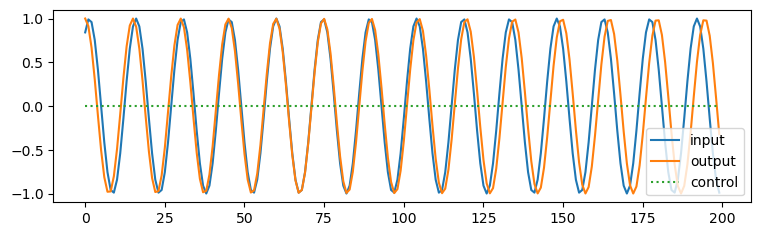

In [46]:
test_PLL(phase_gain=0, freq_gain=0, phase_shift=1, freq_err_perc=2, N=200, M=200)

### Phase offset compensation

Here the input has an initial phase offset and no frequency deviation; only the phase gain is nonzero and the PLL over time gets in lock with the input

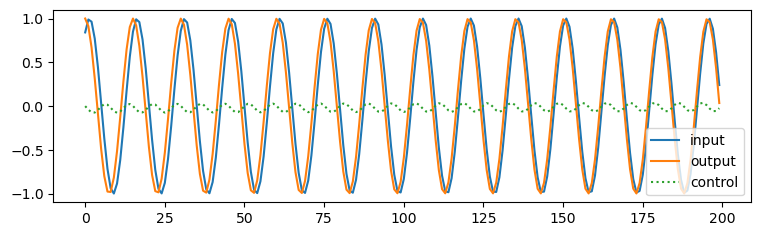

In [48]:
test_PLL(phase_gain=0.01, freq_gain=0, phase_shift=1, freq_err_perc=0, N=200, M=200)

We can see the rate of convergence more clearly over a longer time span

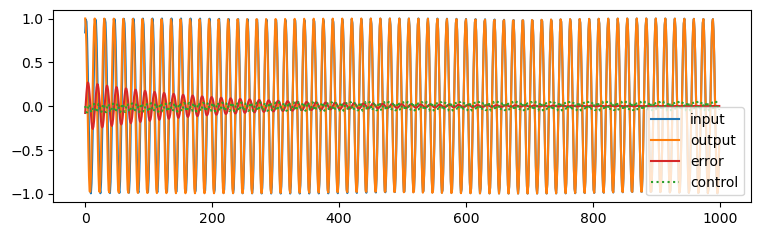

In [50]:
test_PLL(phase_gain=0.01, freq_gain=0, phase_shift=1, freq_err_perc=0, N=1000, M=1000, show_error=True)

### Frequency deviations

Here the input has an initial phase offset and a 5% frequency deviation; with the frequency gain set to zero the PLL cannot get a lock

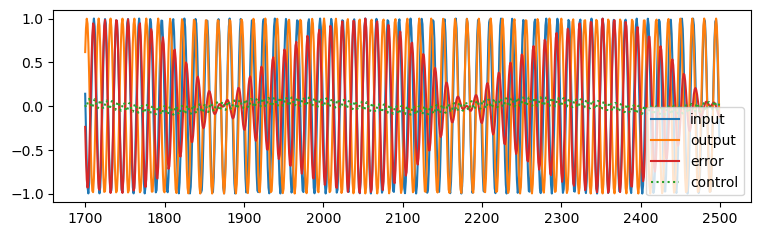

In [52]:
test_PLL(phase_gain=0.01, freq_gain=0, phase_shift=1, freq_err_perc=5, M=800, show_error=True)

By setting the frequency gain $G_f$ to a positive value we can get the PLL to lock over a range of input frequencies

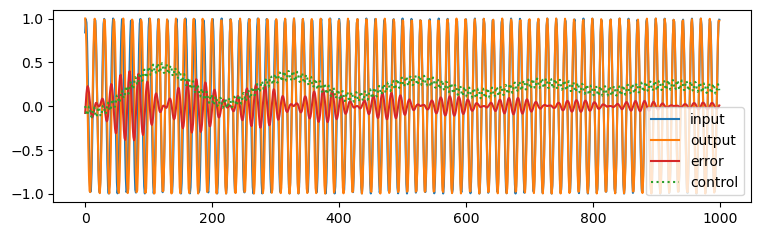

In [54]:
test_PLL(phase_gain=0.01, freq_gain=0.002, phase_shift=1, freq_err_perc=5, N=1000, M=1000, show_error=True)

The PLL's lock range is determined by the value of $G_f$; in this example, the input frequency has become too large (35% deviation) and the PLL cannot lock

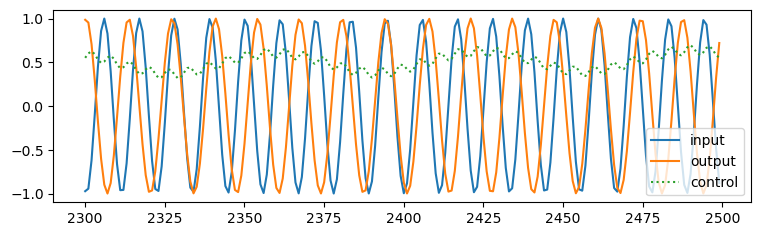

In [56]:
test_PLL(phase_gain=0.01, freq_gain=0.002, phase_shift=1, freq_err_perc=35, M=200)

We can increase the lock range by increasing $G_f$ even more and get the PLL to work also in this case

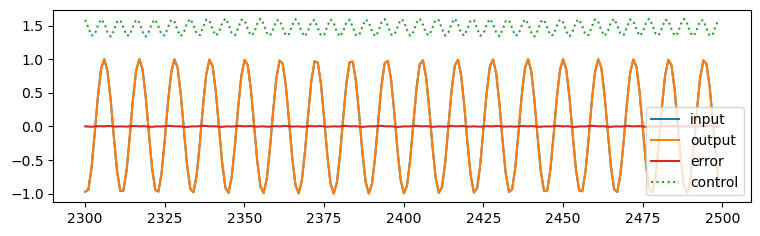

In [58]:
test_PLL(phase_gain=0.01, freq_gain=0.02, phase_shift=1, freq_err_perc=35, M=200, show_error=True)

But a large value for $G_f$ may create problems at low nominal frequencies: the increased gain makes the loop filter too sensitive to the phase estimation error and, as a consequence, the NCO will be slowed down when the input is small (zero crossings) and accelerate when the input peaks:

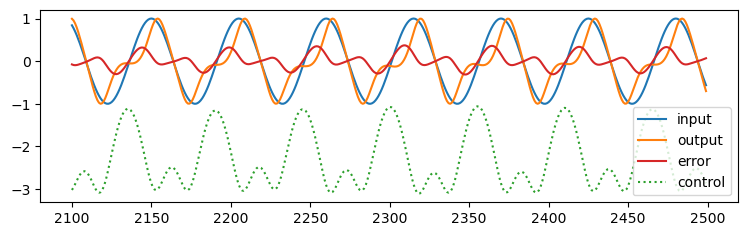

In [60]:
w_slow = 2 * np.pi / 55
test_PLL(wc=w_slow, phase_gain=0.01, freq_gain=0.02, phase_shift=1, freq_err_perc=0, M=400, show_error=True)

Reducing the frequency gain fixes the problem: bottom line, choosing the right gain values can be rather tricky and there is always a tradeoff somewhere!

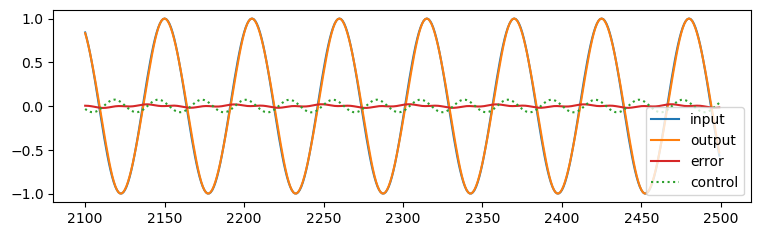

In [62]:
test_PLL(wc=w_slow, phase_gain=0.01, freq_gain=0.002, phase_shift=1, freq_err_perc=0, M=400, show_error=True)

# Synchronization using PLLs

PLL's are very good at detecting sinusoids buried in noise and are thus ideal candidates to improve our synchronization mechanism based on phase reversals in a pilot tone.

## Tone detection

To see if a PLL is in lock with its sinusoidal input, we can look at the local average of the product between the PLL's input and its output:

 * if the PLL is in lock, input and output are always in phase and so their product will always be positive, leading to a positive average value
 * if the PLL is not in lock, the average of the product will be negative or zero.

The following function sets up a PLL at the tone frequency using a relatively small frequency gain for a narrow lock range. The input-output cross product is averaged via a biquad lowpass; to align the detection signal with the input we must compensate for the processing delay introduced by the lowpass, which we can do by first computing its group delay in zero.

In [65]:
class ToneDetector(PLL):
    def __init__(self, wc, phase_gain=0.06, freq_gain=0.0001, smooth=0.99, sf=None):
        super(ToneDetector, self).__init__(wc, phase_gain, freq_gain, sf=sf)
        self.smoother = LPF(1 - smooth, 2)
        # group delay in zero is the derivative of the phase response in zero
        self.delay = int(sp.group_delay(self.smoother, w=[0], fs=2)[1][0])

    def reveal(self, x):
        y, c = self.track(x)
        r = sp.lfilter(*self.smoother, y * x)
        return np.r_[ r[self.delay:], np.zeros(self.delay) ]

    def detect(self, x, threshold=0.1):
        return self.reveal(x) > threshold

In [66]:
detector = ToneDetector(pilot_freq, sf=Fs)

Here we test the tone detector on a clean tone, a noisy tone, and a clean tone at the wrong frequency. Note how the PLL has little trouble achieving lock even when the signal to noise ratio is very low (zero dB in this example); this robustness to noise (which is inversely related to the lock range) makes PLL's ideal devices for signal detection.

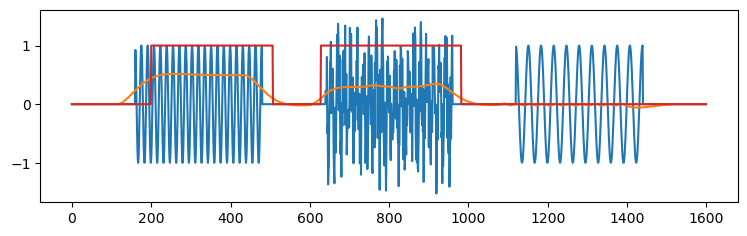

In [68]:
gap = np.zeros(int(Fs * 0.005))
x = np.r_[gap, 
    sync_signal(0.01, rev_point=0), gap, 
    sync_signal(0.01, SNR=0, rev_point=0), gap, 
    sync_signal(0.01, freq_Hz=(0.5 * pilot_freq), rev_point=0), gap
]
plt.plot(x);
plt.plot(detector.reveal(x));
plt.plot(detector.detect(x), 'C3');

## Phase reversal detection

If a PLL in lock state encounters a phase reversal in the input signal, its output signal will remain out of sync with the input until the new phase offset has been compensated for; the duration of this out-of-lock interval will depend on the value of the phase gain $G_p$. 

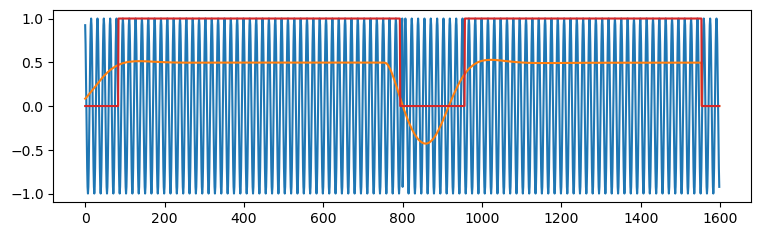

In [70]:
sync = sync_signal(0.05)
plt.plot(sync);
plt.plot(detector.reveal(sync));
plt.plot(detector.detect(sync), 'C3');

We can take advantage of this phenomenon to build a robust phase reversal detector as in the following function. Note that by choosing a small value for the frequency gain $G_f$, the resulting narrow lock range automatically provides excellent noise rejection and no bandpass filtering is needed prior to detection. In the following examples, the phase reversal is correctly detected at an SNR of zero dB even when the pilot frequency deviates non-negligibly from its nominal value.

In [72]:
def PLL_show_pr(x, threshold=0.1, pilot_freq_Hz=2000, sf=32000):
    plt.plot(x);
    plt.plot(ToneDetector(pilot_freq_Hz, sf=sf).detect(x, threshold), 'C3');

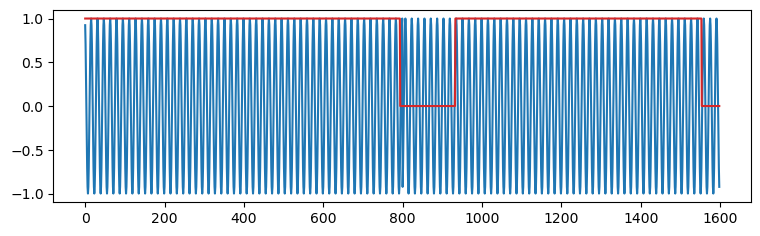

In [73]:
PLL_show_pr(sync_signal(0.05))

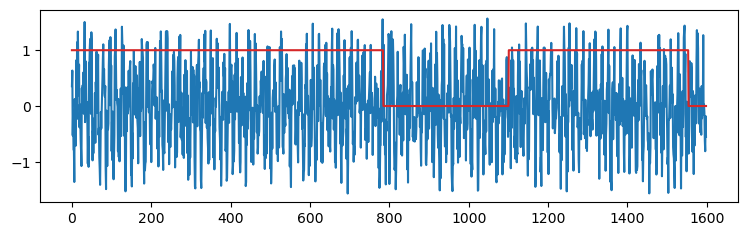

In [74]:
PLL_show_pr(sync_signal(0.05, SNR=0))

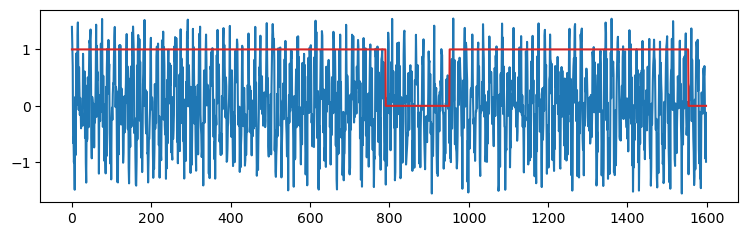

In [75]:
PLL_show_pr(sync_signal(0.05, SNR=0, freq_err_perc=4))

## Automatic Gain Control

The phase reversal detector that we just developed uses a fixed threshold whose value works as long as the incoming pilot signal has unit amplitude (or, alternatively, as long as its average power is equal to 1/2). When this is not the case, detection will fail:

In [78]:
sync_att = sync_signal(0.05, SNR=10) / 10

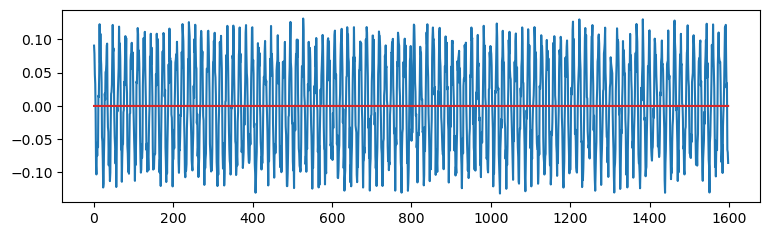

In [79]:
PLL_show_pr(sync_att)

To combat this problem, a practical system will use an Automatic Gain Control module to bring the power of the incoming signal to the expected level. An AGC is an adaptive circuit with the following structure:

<div style="margin: 0;"><img src="img/AGC.png" width="600"></div>


At each "time" instant $n$:
  * the incoming sample is multiplied by a gain factor $a[n]$ to produce the output sample $y[n] = a[n]x[n]$
  * a leaky integrator uses $y[n]$ to update a running estimate of the power of the gain-adjusted signal
  * the power estimate is compared to the desired power level and the (positive or negative) difference is time-averaged by another integrator to update the gain factor

In [81]:
class AGC:
    def __init__(self, target_power=0.5, alpha=0.01, li_tc=0.995):
        self.agc, self.max_agc = 1, 50
        self.target = target_power
        self.avg_power = 0
        self.alpha = alpha
        self.li = li_tc
        
    def set_speed(self, alpha):
        self.alpha = alpha

    def rescale(self, x):
        y = np.zeros(len(x))
        agc = np.zeros(len(x))
        for n in range(0, len(x)):
            agc[n] = self.agc
            y[n] = x[n] * self.agc
            self.avg_power = self.li * self.avg_power + (1 - self.li) * y[n] * y[n]
            self.agc += self.alpha * (self.target - self.avg_power)
            self.agc = max(0, min(self.agc, self.max_agc))
        return y, agc

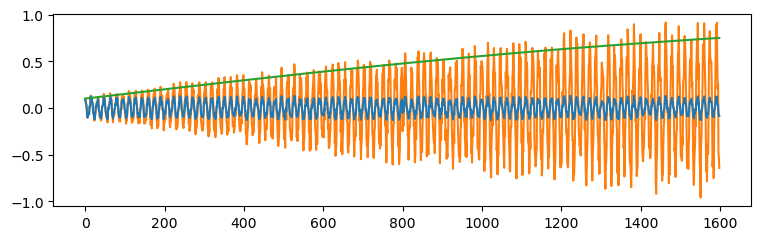

In [82]:
sync_agc, agc = AGC().rescale(sync_att)
plt.plot(sync_agc, 'C1');
plt.plot(sync_att, 'C0');
plt.plot(agc / 10, 'C2');

With this, our phase reversal detector works also with attenuated inputs, provided the pilot tone is long enough for the AGC to converge before the phase reversal occurs.

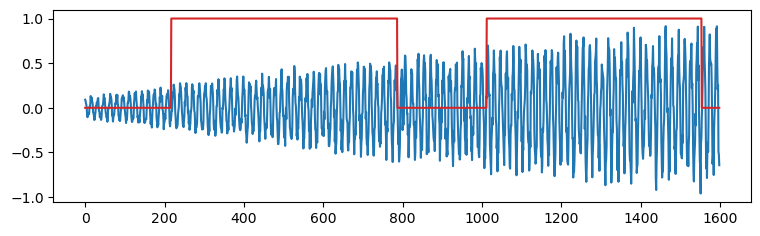

In [84]:
PLL_show_pr(AGC().rescale(sync_att)[0])

# Exercise 1: a PLL for square waves

In the following exercise you are asked to develop a PLL that can operate on square waves instead of sinusoids. Here are some pointers to get you started:

 * the structure of the PLL will remain the same
 * you should modify the NCO so that it produces a square wave instead of a sinusoid; this only requires to change the function $p(\cdot)$ applied to the NCO's phase; for your convenience, below is an implementation that works like a standard trigonometric funcion and returns a balanced, symmetric, $2\pi$-periodic square wave
 * the critical part will be the phase offset estimator; because of the discontinuous and piecewise-constant shape of a square wave, you won't be able to use a simple multiplication-based estimator. You will need to look at the rising and falling edges of input and output to determine their relative alignment
 * the loop filter will remain the same, but the numerical values of $G_p$ and $G_f$ will probably change with respect to the sinusoidal PLL.

In [86]:
def sqw(w):
    # square wave function that works on both scalars and numpy arrays
    w = np.asarray(w)
    scalar_input = w.ndim == 0
    if scalar_input:
        w = w[np.newaxis]

    # in theory we could just
    x = np.sin(w)
    zc = np.isclose(x, 0, atol=1e-10)
    x[zc] = np.cos(w[zc])
    x = np.sign(x)

    return np.squeeze(x) if scalar_input else x

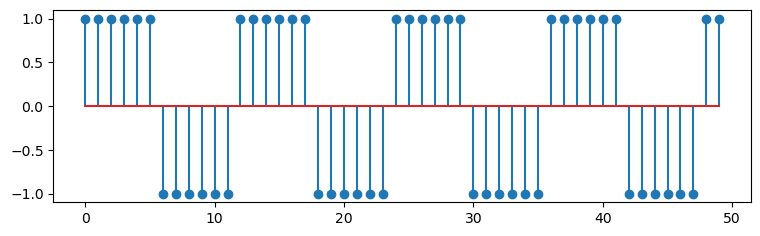

In [87]:
plt.stem(sqw(2 * np.pi / 12 * np.arange(0, 50)));

In [88]:
class SQPLL:
    def __init__(self, wc: float, phase_gain: float, freq_gain: float, sf=None):
        self.wc = 2 * np.pi * wc / sf if sf else wc
        self.gp, self.gi = phase_gain * self.wc, freq_gain
        self.freq_offset = 0
        self.nco_phase = 0

    def track(self, x):
        y = np.zeros(len(x))
        c = np.zeros(len(x))
        
        # your code here...
        
        return y, c

Testing time!

In [90]:
def test_SQPLL(phase_gain, freq_gain, wc=0.35, phase_shift=0, freq_err_perc=0, noise=0, N=2500, M=200, show_error=False):
    x = sqw((1 + freq_err_perc / 100) * wc * np.arange(0, N) + phase_shift) + noise * (np.random.rand(N) - 0.5)
    y, c = SQPLL(wc, phase_gain, freq_gain).track(x)
    
    plt.plot(np.arange(N-M, N), x[-M:], 'C0', label='input')    
    plt.plot(np.arange(N-M, N), y[-M:], 'C1', label='output')
    if show_error:
        plt.plot(np.arange(N-M, N), 0.5 * (x-y)[-M:], 'C3', label='error')
    plt.plot(np.arange(N-M, N), 10 * c[-M:], 'C2:', label='control')
    plt.legend(loc="lower right")

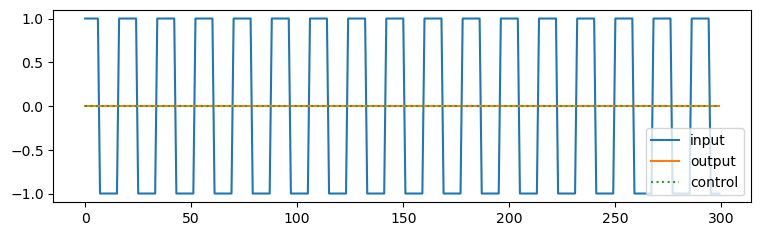

In [91]:
# Phase offset compensation
test_SQPLL(phase_gain=0.05, freq_gain=0, phase_shift=7, freq_err_perc=0, N=300, M=300)

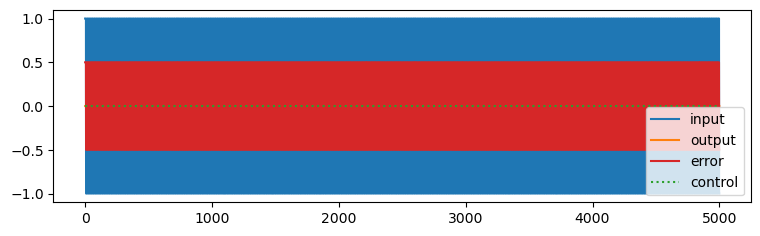

In [92]:
# Phase offset compensation
test_SQPLL(phase_gain=0.05, freq_gain=0, phase_shift=7, freq_err_perc=0, N=5000, M=5000, show_error=True)

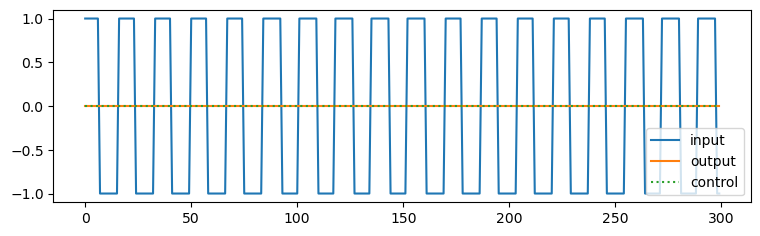

In [93]:
# frequency compensation
test_SQPLL(phase_gain=0.1, freq_gain=0.0005, phase_shift=7, freq_err_perc=5, N=300, M=300)#, show_error=True)

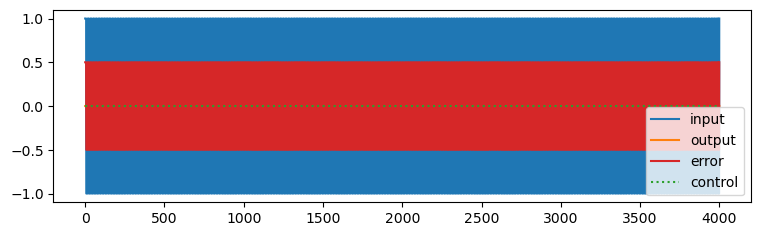

In [94]:
# frequency compensation
test_SQPLL(phase_gain=0.1, freq_gain=0.0005, phase_shift=7, freq_err_perc=5, N=4000, M=4000, show_error=True)

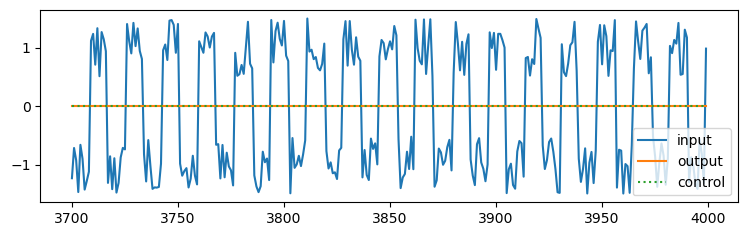

In [95]:
# performance in noise
test_SQPLL(phase_gain=0.1, freq_gain=0.0005, phase_shift=7, freq_err_perc=5, N=4000, M=300, noise=1)

# Exercise 2: an FM radio receiver

In our previous discussion we mentioned that FM modulation can be easily implemented with a NCO. Interestingly, an FM signal can be equally easily demodulated using a single PLL with a narrow lock range around the FM carrier frequency.

The following signal contains an FM-modulated music excerpt with the following characteristics:

  * the signal is sampled at 96 kHz
  * the original music sample, before modulation, was bandlimited to 8 kHz
  * the FM carrier frequency is 38 kHz

In [97]:
fm_sf, fm_signal = wavfile.read("data/fm.wav")
print(f'signal sampled at {fm_sf} Hz')

signal sampled at 96000 Hz


If you play the FM signal you won't hear anything because all the information is now placed outside of hearing range. You can however verify that the signal contains energy in a frequency region centered around the FM carrier

In [99]:
IPython.display.Audio(fm_signal, rate=fm_sf)

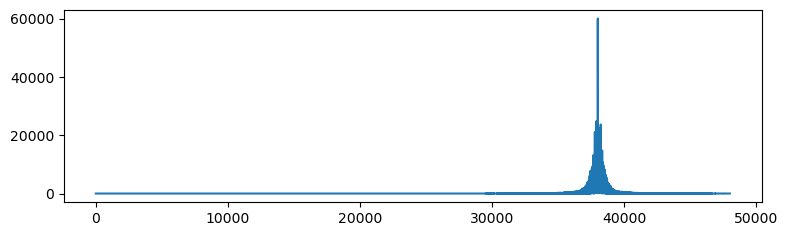

In [100]:
plot_mag_spec(fm_signal, Fs=fm_sf)

Can you use a PLL to demodulate the FM signal and listen to the audio sample?